In [1]:
##import packages
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
import subprocess
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
import os

warnings.filterwarnings('ignore')
import time
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats

from scipy.spatial.distance import cdist
import h5py

import anndata
import torch
import sys


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['figure.dpi'] = 150


First, you must download the scRNA count file and
Put the scRNA count file in :

'FigureData/Figure4/Dataset4_seqFISH+/Rawdata/' and 
'FigureData/Figure4/Dataset4_STARmap/Rawdata/'

The scRNA count link:
https://drive.google.com/file/d/1ugoZtGHwoK6CLGVK4kWehLscqJqNNha4/view?usp=sharing

# 1. Part1 : grid spots with different pixes

In [3]:
### please the vefity that you have installed the Seurat,SpaOTsc,Tangram,novoSpaRc
### please  make sure you are in SpatialBenmarking dir and have prepared the data files
def Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateXlable, CoordinateYlable, window, outdir):
    if os.path.exists(outdir):
        print ('The output file is in ' + outdir)
    else:
        os.mkdir(outdir)
    combined_spot = []
    combined_spot_loc = []
    window=window
    c = 0
    for x in np.arange((spatial_loc[CoordinateXlable].min()//window),spatial_loc[CoordinateXlable].max()//window+1):
        for y in np.arange((spatial_loc[CoordinateYlable].min()//window),spatial_loc[CoordinateYlable].max()//window+1):
            tmp_loc = spatial_loc[(x*window < spatial_loc[CoordinateXlable]) & (spatial_loc[CoordinateXlable] < (x+1)*window) & (y*window < spatial_loc[CoordinateYlable]) & (spatial_loc[CoordinateYlable] < (y+1)*window)]
            if len(tmp_loc) > 0:
                c += 1
                combined_spot_loc.append([x,y])
                combined_spot.append(tmp_loc.index.to_list())
            
    combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot],columns=['cell_count'])
    combined_cell_counts.to_csv(outdir + '/combined_cell_counts.txt',sep='\t')
    combined_cell_counts = pd.read_csv(outdir + '/combined_cell_counts.txt',sep='\t',index_col=0)
    print ('The simulated spot has cells with ' + str(combined_cell_counts.min()[0]) + ' to ' + str(combined_cell_counts.max()[0]))
    combined_spot_loc = pd.DataFrame(combined_spot_loc, columns=['x','y'])
    combined_spot_loc.to_csv(outdir + '/combined_Locations.txt',sep='\t',index=False)


    combined_spot_exp = []
    for s in combined_spot:
        combined_spot_exp.append(spatial_rna.loc[s,:].sum(axis=0).values)
    combined_spot_exp = pd.DataFrame(combined_spot_exp, columns=spatial_rna.columns)
    combined_spot_exp.to_csv(outdir + '/combined_spatial_count.txt',sep='\t',index=False)

    combined_spot_clusters = pd.DataFrame(np.zeros((len(combined_spot_loc.index),len(np.unique(spatial_meta['celltype'])))),columns=np.unique(spatial_meta['celltype']))
    for i,c in enumerate(combined_spot):
        for clt in spatial_meta.loc[c,'celltype']:
            combined_spot_clusters.loc[i,clt] += 1
    combined_spot_clusters.to_csv(outdir + '/combined_spot_clusters.txt',sep='\t')
    print ('The simulated spot has size ' + str(combined_spot_clusters.shape[0]))


# seqFISH+ dataset simulated with 500 pixes

In [4]:
###before you simulated data, please check your cluster name and verfity that the cluster name in both data are same.
###please note that the cluster labels do not contain '/' or ' ' or '&'
time_start=time.time()
PATH = 'FigureData/Figure4/Dataset4_seqFISH+/'

sc_rna = pd.read_csv(PATH + 'Rawdata/scRNA_count.txt', sep='\t',index_col=0, engine='c',low_memory=False)
spatial_rna = pd.read_csv(PATH + 'Rawdata/Spatial_count.txt',sep='\t')
spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]

spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt', sep = '\t', index_col=0)
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations_seqfish.txt',sep='\t')

window = 500
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = PATH + 'Simulated_seqFISH+/'

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir) 
time_end=time.time()
print('seqFISH+ dataset simulated step costs',time_end-time_start,'s')

The output file is in FigureData/Figure4/Dataset4_seqFISH+/Simulated_seqFISH+/
The simulated spot has cells with 1 to 17
The simulated spot has size 72
seqFISH+ dataset simulated step costs 47.3961398601532 s


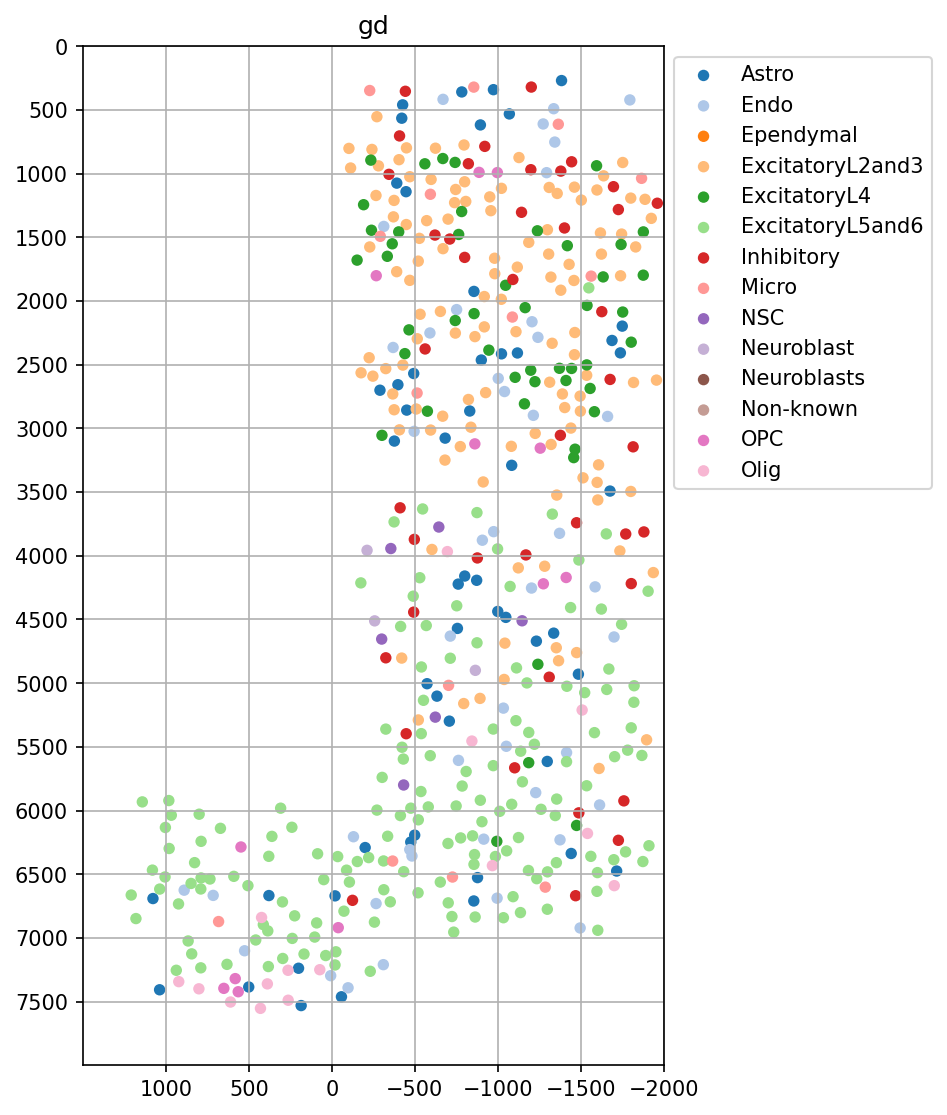

In [5]:
###plot the simulated data image
spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t')
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations_seqfish.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(np.array(spatial_meta.celltype))))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['Y'][:-1],y=spatial_loc[spatial_meta['celltype'] == c]['X'][:-1],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-2000,1500,500))
plt.yticks(np.arange(0,8000,500))
plt.xlim(-2000,1500)
plt.ylim(0,8000)
ax.invert_yaxis()
ax.invert_xaxis()
plt.grid()
plt.show()


# STARmap dataset simulated with 750 pixes

In [8]:
time_start=time.time()
PATH = 'FigureData/Figure4/Dataset10_STARmap/'
sc_rna = pd.read_csv(PATH + 'Rawdata/scRNA_count.txt', sep='\t',index_col=0,engine='c',low_memory=False)
spatial_rna = pd.read_csv(PATH + 'Rawdata/Spatial_count.txt',sep='\t')
spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]
spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t',index_col=0)
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations.txt',sep='\t')

window = 750
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = PATH + 'Simulated_STARmap/'

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir) 
time_end=time.time()
print('STARmap dataset simulated step costs',time_end-time_start,'s')

The output file is in FigureData/Figure4/Dataset10_STARmap/Simulated_STARmap/
The simulated spot has cells with 1 to 17
The simulated spot has size 189
STARmap dataset simulated step costs 33.772244453430176 s


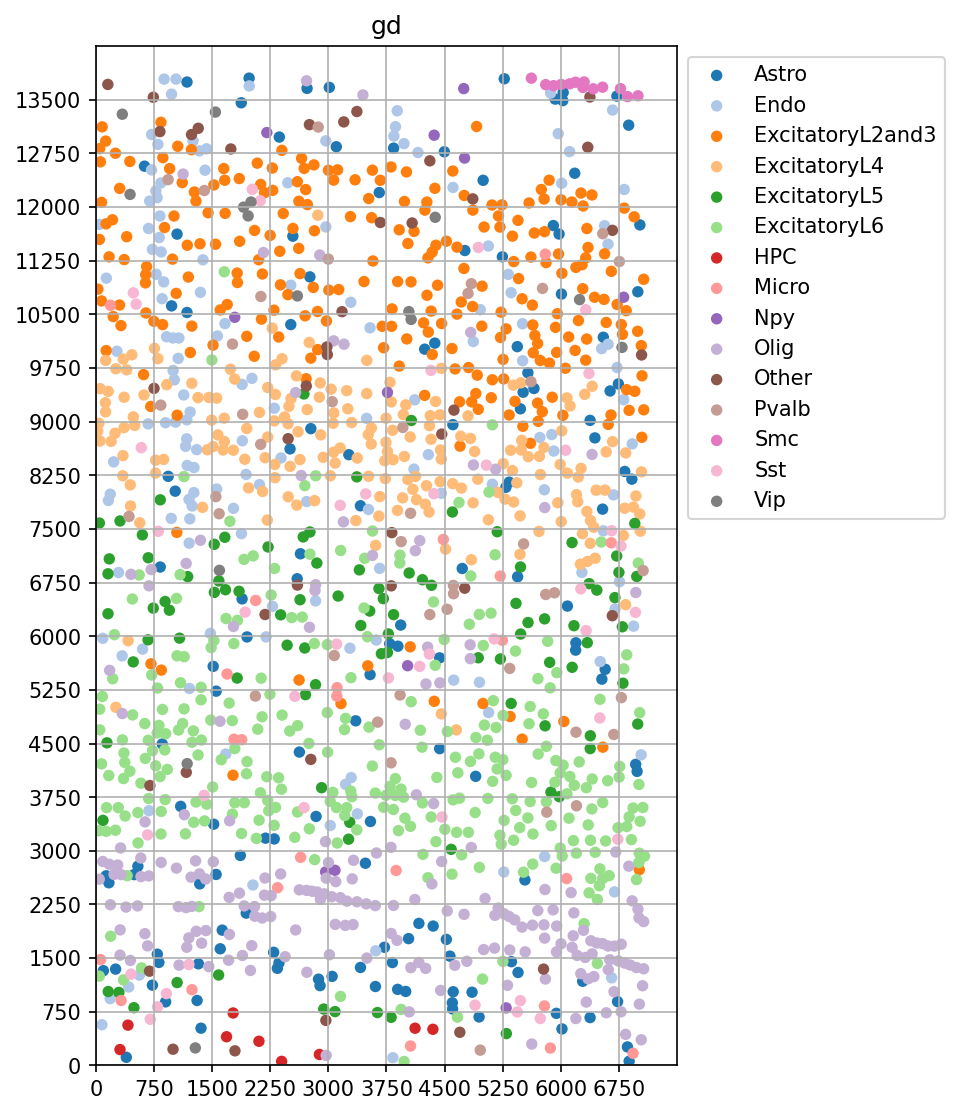

In [9]:

spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t')
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(spatial_meta.celltype)))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['X'],y=spatial_loc[spatial_meta['celltype'] == c]['Y'],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(0,7500,750))
plt.yticks(np.arange(0,14250,750))
plt.xlim(0,7500)
plt.ylim(0,14250)
plt.grid()
plt.show()


# 

# Simulated data from scRNA data

### Please downloads the paired scRNA data (Simulation Test) from : 
### https://drive.google.com/drive/folders/1pHmE9cg_tMcouV1LFJFtbyBJNp7oQo9J


In [5]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from scipy.sparse import csr_matrix, issparse
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from importlib import reload
import sys
sys.path.append('Benchmarking/')
from data_downsample import downsample_matrix_by_cell


In [ ]:
import numpy as np
import pandas as pd
import numba as nb
from numba import jit

def count_cell_counts(cell_counts):
    cell_counts = np.array(cell_counts.values,dtype=int).reshape(-1)
    counts_list = np.array(np.histogram(cell_counts,range=[0,np.max(cell_counts)+1],bins=np.max(cell_counts)+1)[0],dtype=int)
    counts_index = np.array((np.histogram(cell_counts,range=[0,np.max(cell_counts)+1],bins=np.max(cell_counts)+1)[1][:-1]),dtype=int)
    counts_df = pd.DataFrame(counts_list,index=counts_index,columns=['count'],dtype=np.int32)
    counts_df = counts_df[(counts_df['count'] != 0) & (counts_df.index != 0)]
    count_sum = 0
    for i in np.arange(len(counts_df)):
        count_sum += counts_df.iloc[i].values
        if count_sum > counts_df.values.sum()*0.99:
            counts_df_filtered = counts_df.iloc[:i+1,:]
            break
    return counts_df_filtered
@nb.njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1], dtype=arr.dtype)
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0], dtype=arr.dtype)
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result
@nb.njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)
@nb.njit
def np_sum(array, axis):
    return np_apply_along_axis(np.sum, axis, array)

@jit(nopython=True,parallel=True)
def sample_cell(param_list,cluster_p,clusters,sc_rna_celltypes,sample_exp,sample_cluster,cell_p_balanced):
    exp = np.empty((len(param_list), sample_exp.shape[1]))
    density = np.empty((len(param_list), sample_cluster.shape[1]))

    for i in nb.prange(len(param_list)):
        params = param_list[i]
        num_cell = params[0]
        num_cluster = params[1]
        used_clusters = clusters[np.searchsorted(np.cumsum(cluster_p), np.random.rand(num_cluster), side="right")]

        cluster_mask=np.array([False]*len(sc_rna_celltypes))
        for c in used_clusters:
            cluster_mask = (sc_rna_celltypes==c)|(cluster_mask)

        used_cell_ind = np.where(cluster_mask)[0]
        used_cell_p = cell_p_balanced[cluster_mask]
        used_cell_p = used_cell_p/used_cell_p.sum()

        sampled_cells=used_cell_ind[np.searchsorted(np.cumsum(used_cell_p), np.random.rand(num_cell), side="right")]
        combined_exp=np_sum(sample_exp[sampled_cells,:],axis=0)
        combined_clusters=np_sum(sample_cluster[sc_rna_celltypes[sampled_cells]],axis=0)
        exp[i,:] = combined_exp
        density[i,:] = combined_clusters
    return exp,density

class Sampler:
    def __init__(self,sc_ann,celltype_key,marker_genes,cells_mean,cells_std,colocated_mean,colocated_std,min_cell,max_cell):
        self.sc_ann = sc_ann
        self.init_sample_prob(celltype_key)
        self.cells_mean = cells_mean
        self.cells_std = cells_std
        self.colocated_mean = colocated_mean
        self.colocated_std = colocated_std
        self.min_cell=min_cell,
        self.max_cell=max_cell,
        self.sample_exp = self.generate_sample_array(marker_genes)
        self.clusters = np.array(sc_ann.uns['cluster_p_sqrt'].index.values)
        self.sample_cluster = np.eye(len(self.clusters))
        self.sc_rna_celltypes = np.array(sc_ann.obs['celltype_num'].values)
        
    def init_sample_prob(self,celltype_key):
        self.sc_ann.uns['celltype2num'] = pd.DataFrame(
            np.array(np.arange(len(self.sc_ann.obs[celltype_key].unique()))).T,
            index=self.sc_ann.obs[celltype_key].unique(),
            columns=['celltype_num']
        )
        self.sc_ann.obs['celltype_num'] = [self.sc_ann.uns['celltype2num'].loc[c,'celltype_num'] for c in self.sc_ann.obs[celltype_key]]
        self.sc_ann.obs['celltype_num'].value_counts()
        cluster_p_unbalance = self.sc_ann.obs['celltype_num'].value_counts()/self.sc_ann.obs['celltype_num'].value_counts().sum()
        cluster_p_sqrt = np.sqrt(self.sc_ann.obs['celltype_num'].value_counts())/np.sqrt(self.sc_ann.obs['celltype_num'].value_counts()).sum()
        cluster_p_balance = pd.Series(
            np.ones(len(self.sc_ann.obs['celltype_num'].unique()))/len(self.sc_ann.obs['celltype_num'].unique()), 
            index=self.sc_ann.obs['celltype_num'].unique()
        )
        cell_p_balanced = [1/cluster_p_unbalance[c] for c in self.sc_ann.obs['celltype_num']]
        cell_p_balanced = np.array(cell_p_balanced)/np.array(cell_p_balanced).sum()
        self.sc_ann.obs['cell_p_balanced'] = cell_p_balanced
        self.sc_ann.uns['cluster_p_balance'] = cluster_p_balance
        self.sc_ann.uns['cluster_p_sqrt'] = cluster_p_sqrt/cluster_p_sqrt.sum()
        self.sc_ann.uns['cluster_p_unbalance'] = cluster_p_unbalance/cluster_p_unbalance.sum()
    
    def generate_sample_array(self, marker_genes):
        sc_df = self.sc_ann.to_df().loc[:,marker_genes]
        return sc_df.values

    def sample_data(self, num_sample: int, balance=None,cell_sampler=None,cluster_sampler=None):
        cell_count = np.asarray(np.ceil(np.clip(np.random.uniform(5,15,size=num_sample),self.min_cell,self.max_cell)),dtype=int)
        colocated_count = np.asarray(np.ceil(np.clip(np.random.uniform(2,6,size=num_sample),1,cell_count)),dtype=int)
        params = np.array(list(zip(cell_count, colocated_count)))
        if balance is None:
            cluster_p = self.sc_ann.uns['cluster_p_unbalance'].values
        elif balance == 'balance':
            cluster_p = self.sc_ann.uns['cluster_p_balance'].values
        elif balance == 'sqrt':
            cluster_p = self.sc_ann.uns['cluster_p_sqrt'].values
        else:
            raise TypeError('balance must be one of [None,banlance,sqrt].')
        return sample_cell(params,cluster_p,self.clusters,self.sc_rna_celltypes,self.sample_exp,self.sample_cluster,self.sc_ann.obs['cell_p_balanced'].values)
    
    

In [ ]:
def cal_n_count(ann):
    if ann.raw:
        n_count = ann.raw.X.sum(axis=1)
    else:
        n_count = ann.X.sum(axis=1)
    return n_count

def check_adata(ann,save_path):
    save=False
    if ann.raw is not None:
        print('convert raw to adata.')
        old_var = ann.var
        ann = ann.raw.to_adata()
        if '_index' in ann.var.columns:
            ann.var.index = ann.var['_index'].values
            ann.var = ann.var.drop(columns='_index')
        save=True
    if not issparse(ann.X):
        print('convert mtx to sparse.')
        ann.X = csr_matrix(ann.X)
        save=True
    if save:
        print('write new anndata to: ',save_path)
        ann.write_h5ad(save_path)
    return ann

def check_dataset(scRNADir1, scRNADir2, top_genes = 100, plot = False, reverse = False,check = True):
    celltype_meta_1 = pd.read_csv(scRNADir1 + '/celltype_meta.csv', index_col = 0)
    celltype_meta_2 = pd.read_csv(scRNADir2 + '/celltype_meta.csv', index_col = 0)
    overlaped_celltype = np.intersect1d(celltype_meta_1['celltype_final'].unique(),celltype_meta_2['celltype_final'].unique())
    overlaped_celltype = overlaped_celltype[overlaped_celltype!='Not_specific']
    print(overlaped_celltype)

    assert len(celltype_meta_1['celltype_final'][celltype_meta_1['celltype_final'] != 'Not_specific'].unique()) == len(overlaped_celltype), data_ident_1+': unique celltype length dont match.'
    assert len(celltype_meta_2['celltype_final'][celltype_meta_2['celltype_final'] != 'Not_specific'].unique()) == len(overlaped_celltype), data_ident_2+': unique celltype length dont match.'

    data_1 = sc.read_h5ad(scRNADir1 + '/scRNA.h5ad')
    data_2 = sc.read_h5ad(scRNADir2 + '/scRNA.h5ad')

    data_1 = check_adata(data_1, os.path.join(scRNADir1, 'Processed_scRNA.h5ad'))
    data_2 = check_adata(data_2, os.path.join(scRNADir2, 'Processed_scRNA.h5ad'))
    
    data_1.var_names_make_unique()
    data_2.var_names_make_unique()
    data_1.obs_names_make_unique()
    data_2.obs_names_make_unique()
    
    data_1.uns['celltype_mapper'] = celltype_meta_1
    data_2.uns['celltype_mapper'] = celltype_meta_2
    
    n_count_1 = cal_n_count(data_1)
    assert (n_count_1 - np.ceil(n_count_1)).sum() == 0, data_ident_1+': mtx is not raw count.'
    n_count_2 = cal_n_count(data_2)
    assert (n_count_2 - np.ceil(n_count_2)).sum() == 0, data_ident_2+': mtx is not raw count.'
    data_density_1 = (data_1.X!=0).toarray().sum()/data_1.X.toarray().size
    data_density_2 = (data_2.X!=0).toarray().sum()/data_2.X.toarray().size     

    norm_1 = sc.pp.normalize_total(data_1, target_sum=1e6,inplace=False)
    norm_2 = sc.pp.normalize_total(data_2, target_sum=1e6,inplace=False)
    norm_1 = sc.pp.log1p(norm_1['X'],copy=True)
    norm_2 = sc.pp.log1p(norm_2['X'],copy=True)
    data_1.layers['norm'] = norm_1
    data_2.layers['norm'] = norm_2
    print(data_1.obs['celltype'].unique())
    print(data_2.obs['celltype'].unique())
    celltype_meta_1.index = celltype_meta_1.index.fillna('NA')
    celltype_meta_2.index = celltype_meta_2.index.fillna('NA')
    data_1.obs['celltype_final'] = [celltype_meta_1.loc[c,'celltype_final'] for c in data_1.obs['celltype']]
    data_2.obs['celltype_final'] = [celltype_meta_2.loc[c,'celltype_final'] for c in data_2.obs['celltype']]
    sc.pp.filter_cells(data_1,min_genes=1)
    sc.pp.filter_cells(data_2,min_genes=1)
    sc.pp.filter_genes(data_1,min_cells=1)
    sc.pp.filter_genes(data_2,min_cells=1)
    data_1 = data_1[data_1.obs['celltype_final'] != 'Not_specific'].copy()
    data_2 = data_2[data_2.obs['celltype_final'] != 'Not_specific'].copy()
    if plot == True:
        sc.tl.rank_genes_groups(data_1,groupby='celltype_final',layer='norm',use_raw=False)
        sc.tl.rank_genes_groups(data_2,groupby='celltype_final',layer='norm',use_raw=False)
        df = pd.DataFrame(
            np.zeros((len(np.unique(data_1.obs['celltype_final'])),len(np.unique(data_2.obs['celltype_final'])))),
            index=np.unique(data_1.obs['celltype_final']),
            columns=np.unique(data_2.obs['celltype_final']),
        )
        for c1 in np.unique(data_1.obs['celltype_final']):
            for c2 in np.unique(data_1.obs['celltype_final']):
                markers_df_1 = sc.get.rank_genes_groups_df(data_1,group=c1)
                markers_1 = markers_df_1.head(top_genes)['names']
                markers_df_2 = sc.get.rank_genes_groups_df(data_2,group=c2)
                markers_2 = markers_df_2.head(top_genes)['names']
                markers_inter = np.intersect1d(markers_1,markers_2)
                markers_union = np.union1d(markers_1,markers_2)
                df.loc[c1,c2] = len(markers_inter)/len(markers_union)
        fig,ax = plt.subplots(figsize=(4,4))
        sns.heatmap(df,ax=ax,xticklabels=True,yticklabels=True)
        plt.title(f'dataset{str(dataset)}_jaccard_ind')
        plt.show()
        if check:
            assert np.abs(np.argmax(df.values,axis=0) - np.arange(len(df))).sum() == 0, 'celltype similarity error.'
    if data_density_1 > data_density_2 :
        if not reverse:
            return data_1, data_2
        else:
            return data_2, data_1
    else:
        if not reverse:
            return data_2, data_1
        else:
            return data_1, data_2
        
        

In [ ]:
def generate_spatial_data(
    sc_ann, 
    celltype_key, 
    mean_cells, 
    std_cells, 
    mean_celltypes, 
    std_celltypes, 
    save_path,
    min_cell=4,
    max_cell=16,
    size=1000
):
    sampler = Sampler(sc_ann,celltype_key,sc_ann.var_names,mean_cells,std_cells,mean_celltypes,std_celltypes,min_cell,max_cell)
    exp,density = sampler.sample_data(size,balance=None)
    spatial_ann = anndata.AnnData(exp)
    spatial_ann.var.index = sc_ann.var_names
    spatial_ann.obs['cell_counts'] = density.sum(axis=1)
    spatial_ann.uns['density'] = pd.DataFrame(density, columns=sc_ann.obs[celltype_key].unique())
    del exp,density
    ds_mtx = downsample_matrix_by_cell(spatial_ann.X,fraction=0.1)
    spatial_ann.X = ds_mtx
    spatial_ann.write_h5ad(os.path.join(save_path))
    return spatial_ann



In [ ]:
def generate_dataset_data(scRNADir1, scRNADir2, celltype_key,reverse = False):
    scrna, spatial = check_dataset(scRNADir1, scRNADir2, top_genes=200, plot=False,reverse=reverse,check=False)
    if not reverse:
        output_dir = scRNADir1
    else:
        output_dir = scRNADir2
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    generate_spatial_data(spatial,celltype_key,5,3,3,1.5,save_path = output_dir + '/SimulatedSpatial.h5ad')
    if len(scrna.obs) > 10000:
        scrna = scrna[np.random.permutation(scrna.obs_names)[:10000]].copy()
    scrna.obs = scrna.obs.loc[:,['celltype_final']]
    celltype_counts = scrna.obs.celltype_final.value_counts()
    celltype_drop = celltype_counts.index[celltype_counts < 2]
    print(f'Drop celltype {list(celltype_drop)} contain less 2 sample')
    scrna = scrna[~scrna.obs.celltype_final.isin(celltype_drop),]
    sc.pp.normalize_total(scrna, target_sum=1e4)
    sc.pp.log1p(scrna)
    sc.tl.rank_genes_groups(scrna,groupby='celltype_final')
    scrna.write_h5ad(output_dir + '/Simulated_scRNA.h5ad')


In [ ]:
scRNADir1 = 'Brain_10X'
scRNADir2 = 'Brain_Smart-seq'

generate_dataset_data(scRNADir1, scRNADir2, celltype_key = 'celltype_final',reverse = False)
generate_dataset_data(scRNADir1, scRNADir2, celltype_key = 'celltype_final',reverse = True)
